# Amazon Apparel Recommendation

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'bs4'

# Terminology
- What is a dataset?
- Rows and Columns
- Data Point
- Feature/variable

In [ ]:
data = pd.read_json('tops_fashion.json')
data

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183133,None,B01MSALTSO,OUTERWEAR,$14.58,None,Black,TOOGOO(R),None,Usually ships in 1-2 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,NaN,TOOGOO(R) Women's Tops Spring Autumn Casual Pu...,089106A4,https://images-na.ssl-images-amazon.com/images...,None,<b>* TOOGOO is a registered trademark. ONLY Au...
183134,None,B015W98YQK,SHIRT,None,None,Monochrome Plaid,VOGUE CODE,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,NaN,VOGUE CODE Vintage V Neck Plaid Shirt Sleevele...,None,https://images-na.ssl-images-amazon.com/images...,None,"SIZE CHART <p> XS for length of front 27.6""; l..."
183135,None,B075756PGC,SHIRT,None,None,Pink,Wrangler,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,NaN,Wrangler George Strait For Her Long Sleeve Pin...,LGS7089,https://images-na.ssl-images-amazon.com/images...,None,Pretty pink print button down Western shirt fr...
183136,None,B074L8FVTT,SHIRT,$44.99,None,Rose,susana monaco,susana monaco,Usually ships in 2-3 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,NaN,Susana Monaco Womens Susana Monoco Sleeveless ...,None,https://images-na.ssl-images-amazon.com/images...,susana monaco,Color/pattern: rose. Approximately 23in from s...


In [ ]:
print(data.shape)

(183138, 19)


In [ ]:
#Each product/item has 19 features in the raw dataset
data.columns #print column-names or features-name

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

# Feature Mining
Out of these 19 features we will use 6
- asin (Amazon Standard identification number) -> primary key or unique id
- brand (brand to which the product belongs to)
- color (Color information of apparel, it contains many colors as a value ex. red and black stripes
- product_type_name (type of the apparel , ex: SHIRT/TSHIRT)
- medium_image_url (url of the image)
- title (title of the product)
- formatted_price (price of the product)

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


# Missing datfor various Features (EDA)

# product_type_name

In [ ]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [ ]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [ ]:
product_type_count = Counter((data['product_type_name']))
(product_type_count.most_common(10))

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

# Brand

In [ ]:
data['brand'].describe()

NameError: name 'data' is not defined

In [ ]:
brand_count = Counter((data['brand']))
brand_count.most_common(10)

NameError: name 'Counter' is not defined

# Color

In [5]:
print(data['color'].describe())

NameError: name 'data' is not defined

In [13]:
color_count = Counter(data['color'])
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

# formatted_price

In [14]:
data['formatted_price'].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [15]:
price_count = Counter(data['formatted_price'])
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [16]:
data['title'].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

In [17]:
data.to_pickle('pickles/180k_apparel_data')

We save data files at every major step in our processing in 'pickel' files. If you are stuck anywhere (or) if some code takes too long to run on your laptop , you may use the pickle files , they help us to speed things up 

In [1]:
#Consider product which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price ==  None/Null
data = data.loc[~data['formatted_price'].isnull()]
data.shape[0]
data = data.loc[~data['color'].isnull()]
data.shape[0]

NameError: name 'data' is not defined

In [19]:
data.to_pickle('pickles/28k_apparel_data')

In [20]:
# You can download all these 28k images using this code below.
# You do NOT need to run this code and hence it is commented.


'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')


'''

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/28k_images/'+row['asin']+'.jpeg')\n\n\n"

# Remove near duplicate items

In [21]:
data = pd.read_pickle('pickles/28k_apparel_data')
(data.duplicated('title'))
#find number of products that have duplicate titles
print(sum(data.duplicated('title')))

2326


In [22]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [23]:
#Remove all products with very few words in title
data_sorted = data[data['title'].apply(lambda x : len(x.split())>4)]
data_sorted.shape

(27958, 7)

- Some examples of duplicate titles that differ only in last few words 

- Title 1:
    - 16. woman's place is in the house and the senate shirts for Women XXL White
    - 17. woman's place is in the house and the senate shirts for Women M Gray

- Title 2:
    - 25. tokidoki The Queen of Diamonds Women's Shirt X-large
    - 26. tokidoki The Queen of Diamonds Women's Shirt large
    - 27. tokidoki The Queen of Diamonds Women's Shirt small

In [24]:
#Sort the whole data based on title (alphabetical order of title)
data_sorted.sort_values('title', inplace = True, ascending = False)

In [25]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

# indices

In [30]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    previous_i = i
    
    #store the list of words of ith string in a ex: a = ['tokidoki','The','Queen'...'X-large'
    a = data['title'].loc[indices[i]].split()
    
    j = i+1
    # search for similar products sequentially
    while j< num_data_points:
        
        #store the list of words jth string in b: b = [['tokidoki','The','Queen'...'large']
        b = data['title'].loc[indices[j]].split()
        
        #store the length of maximum length out of two \
        length = max(len(a), len(b))
        
        count = 0;
        
        for k in itertools.zip_longest(a,b):
            if(k[0] == k[1]):
                count+=1
        
        if ( length-count) > 2:
            
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
        
            if j == num_data_points-1:
                stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])
                
            i = j
            break
            
        else:
            j += 1
        
    if previous_i == i:
        break
        

In [31]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [32]:
data.shape

(17597, 7)

In [33]:
data.to_pickle('pickles/17k_apperal_data')

In [34]:
data = pd.read_pickle('pickles/17k_apperal_data')

# Remove Duplicates Part - 2

- In the previous cell, we sorted whole data in alphabetical order of titles. Then we removed titles which are adjacent and very similar titles
- but there are some titles whose titles  are not adjacent but very similar 

- Examples 
- Title-1:
    - 86261 UltraClub Women's Classic Wrinkle-Freee Long Sleeve Oxford Shirt, Pink, XX- Large
    - 115042 UltraClub Ladies Classic Wrinkle-Freee Long Sleeve Oxford Shirt, light blue, XX- Large

In [39]:
indices = []
for i,row in data.iterrows():
    indices.append(i)


stage2_dedupe_asins = []
while len(indices) != 0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    
    a = data['title'].loc[i].split()
    
    for j in indices:
        
        b = data['title'].loc[j].split()
        
        
        length = max(len(a), len(b))
        
        count = 0
        
        for k in itertools.zip_longest(a,b):
            if( k[0] == k[1]):
                count+=1
        
        if (length - count) < 3:
            indices.remove(j)
                
    

a = data['title'].loc[i].split()
- Consider the first apperal's title
- store the list of words of ith string in a 

for j in indices:
b = data['title'].loc[j].split()
- store the list of words of jth string in b

count = 0
- count is used to store the number of words that matched in both strings 

- itertools.zip.longest(a,b) , will map the corresponding words in both strings, it will append
 example : a = ['a','b','c','d']
 b = ['a','b','d']

In [40]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [41]:
data.shape

(796, 7)

In [42]:
data.to_pickle('pickles/16k_apperal_data')

# Text Pre-Processing

In [43]:
data = pd.read_pickle('pickles/16k_apperal_data')

# NLTK dwnload stopwords [Run only once]
# goto Terminal or cmd
# In the terminal type these commands
# $ python
# $ import nltk
# $ nltk.download()

In [44]:
# we use the list of stopwords that are downloaded from nltk lib
stop_words =  set(stopwords.words('english'))
print('list of stop words: ',stop_words)

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
          #remove the special  chars in review like '"$@!&()_+-?>< etc.
          word = ("".join(e for e in words if e.isalnum()))
          # Convert all letters to loer-case
          word=word.lower()
          # Stop-word removal
          if not word in stop_words:
            string += word + " "
        
        data[column][index]=string


list of stop words:  {'same', 'few', 'own', 'an', 'these', 's', 'haven', 'and', 'yourself', 'doing', 'shouldn', 'mightn', "weren't", 'them', 'themselves', 'into', "you'd", 'more', "won't", 'm', 'so', 'was', 'ourselves', "shan't", 'she', 'shan', 'why', 'isn', 'hadn', 'a', 'their', 'against', 'they', 'this', 'can', "that'll", 'with', "it's", 'he', 'here', 'those', 'your', "you'll", 'her', 'mustn', "mustn't", 'its', 'after', 'any', 'doesn', "she's", 'be', 'not', "don't", 've', 'yours', 'as', 't', 'we', 'just', 'what', "hasn't", 'him', 'between', 'until', 'will', 'up', 'y', 'am', "aren't", 'o', 'our', 'while', 'won', 'ain', 'no', 'there', 'again', 'such', 'for', 'wasn', 'in', 'above', 'but', 'needn', 'll', 'who', 'if', 'to', 'over', 'aren', 'hers', "isn't", 'd', 'it', 'out', 'off', 'from', 'about', 'has', 'which', 'ours', 'should', 're', 'theirs', "you're", 'couldn', 'been', 'too', 'of', 'down', 'where', 'nor', 'didn', 'the', "you've", 'below', 'then', "should've", "didn't", 'hasn', "needn

In [45]:
start_time = time.process_time()

for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

print(time.process_time() - start_time, " seconds")

0.21875  seconds


In [46]:
data.head()
data.shape

(796, 7)

In [47]:
data.to_pickle('pickles/16k_apperal_data_preprocessed')

# Stemming
### stemming doesn't work very well

In [48]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))

argu
fish


# Text based product similarity

In [49]:
data = pd.read_pickle('pickles/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
173906,B01LWPTGCG,Blooming Jelly,Red,https://images-na.ssl-images-amazon.com/images...,SHIRT,blooming jelly long sleeve semi sheer lace blo...,$8.99
173910,B00RALXRK2,August Silk,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,august silk womens plus size slvlss vneck butt...,$45.99
173916,B073VN5DTB,BLady,Lightbluefl,https://images-na.ssl-images-amazon.com/images...,SHIRT,blady women colorful printed cotton polyester ...,$13.99
173922,B014E34XIS,Anna-Kaci,Grey/White,https://images-na.ssl-images-amazon.com/images...,SHIRT,anna kaci sm fit urban hip hop grey white intr...,$14.45
173925,B00CF4GDUA,ELAN,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,elan bubble vneck top white medium,$39.99


In [50]:


#Display an image

def display_img(url, ax, fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    
#plotting code to understand the algo's decision
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()

def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)


# Bag of Words (BoW) on product titles

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
#title_features.shape = # data_point + # words in corpus
# CountVectorizer.fit_transform(corpus) returns 
# the sparse matrix of dimensions # data points + # words in corpus

(796, 1414)

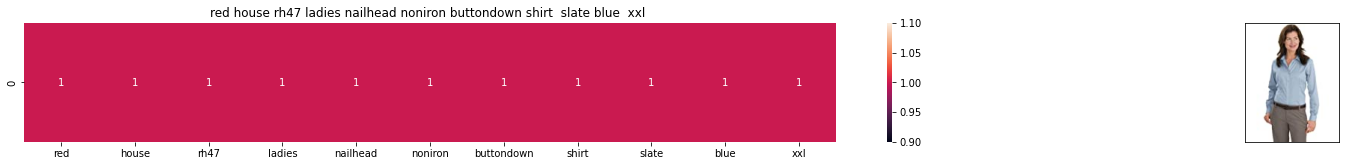

ASIN : B00884JNA8
Brand: Red House
Title: red house rh47 ladies nailhead noniron buttondown shirt  slate blue  xxl 
Euclidean similarity with the query image : 0.0


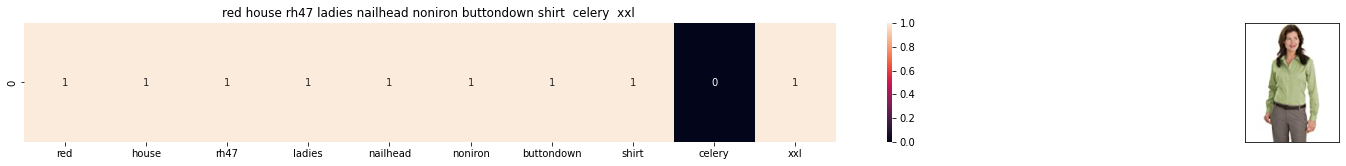

ASIN : B00884JM0Y
Brand: Red House
Title: red house rh47 ladies nailhead noniron buttondown shirt  celery  xxl 
Euclidean similarity with the query image : 1.7320508075688772


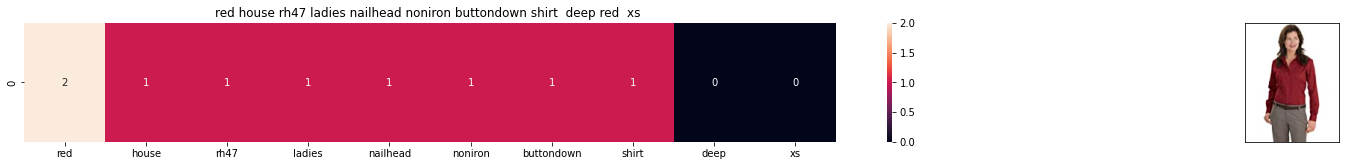

ASIN : B00884JJMA
Brand: Red House
Title: red house rh47 ladies nailhead noniron buttondown shirt  deep red  xs 
Euclidean similarity with the query image : 2.449489742783178


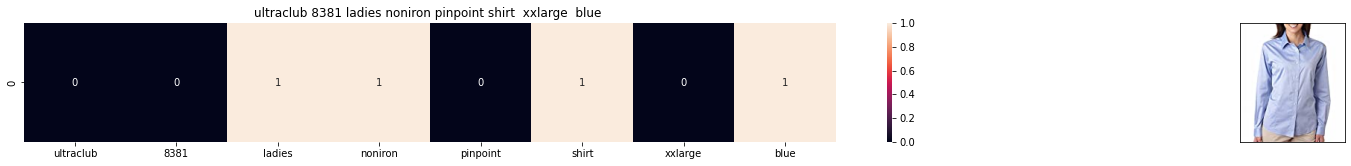

ASIN : B00BPXMNQK
Brand: UltraClub
Title: ultraclub 8381 ladies noniron pinpoint shirt  xxlarge  blue 
Euclidean similarity with the query image : 3.3166247903554


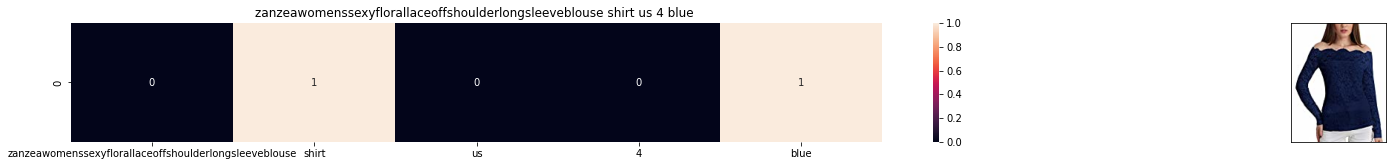

ASIN : B01192N6GC
Brand: ZANZEA
Title: zanzeawomenssexyflorallaceoffshoulderlongsleeveblouse shirt us 4 blue 
Euclidean similarity with the query image : 3.3166247903554


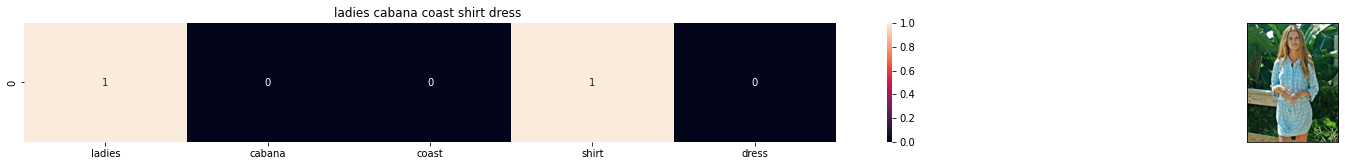

ASIN : B07572PP29
Brand: HAVEN
Title: ladies cabana coast shirt dress 
Euclidean similarity with the query image : 3.4641016151377544


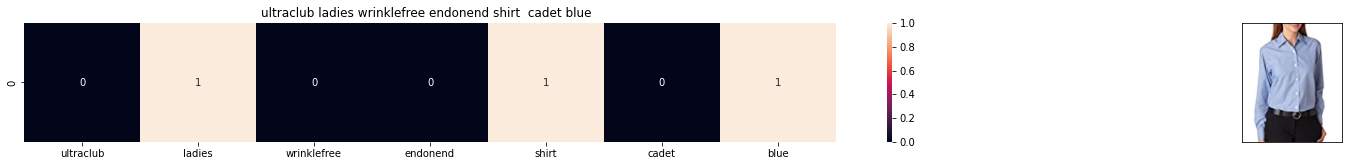

ASIN : B008LT18KS
Brand: UltraClub
Title: ultraclub ladies wrinklefree endonend shirt  cadet blue  
Euclidean similarity with the query image : 3.4641016151377544


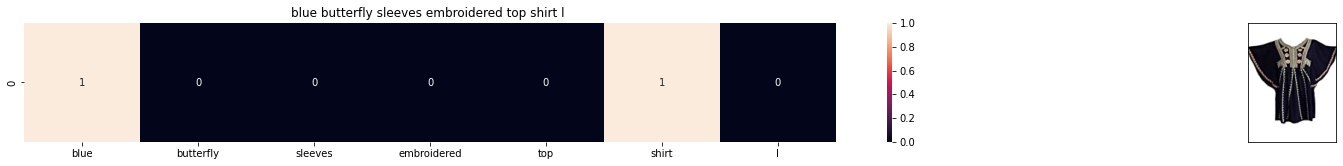

ASIN : B01EXCAGBI
Brand: Sacred Threads Sample/Lobo Tag
Title: blue butterfly sleeves embroidered top shirt l 
Euclidean similarity with the query image : 3.605551275463989


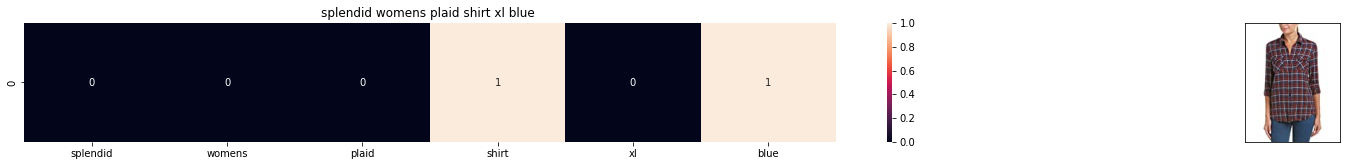

ASIN : B072KNKP98
Brand: Splendid
Title: splendid womens plaid shirt xl blue 
Euclidean similarity with the query image : 3.605551275463989


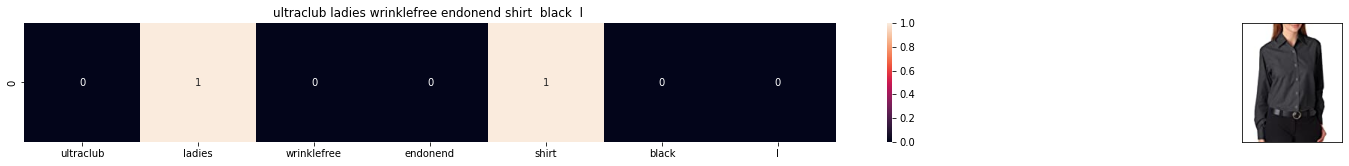

ASIN : B008LT16KU
Brand: UltraClub
Title: ultraclub ladies wrinklefree endonend shirt  black  l 
Euclidean similarity with the query image : 3.605551275463989


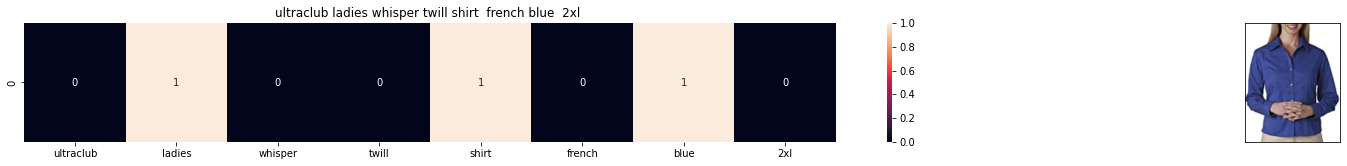

ASIN : B006R7UTU6
Brand: UltraClub
Title: ultraclub ladies whisper twill shirt  french blue  2xl 
Euclidean similarity with the query image : 3.605551275463989


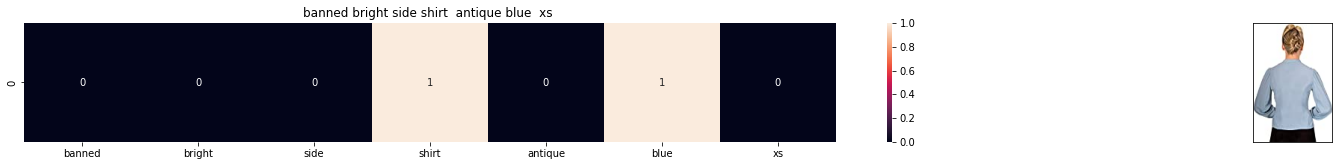

ASIN : B017NU1G6G
Brand: Banned
Title: banned bright side shirt  antique blue  xs 
Euclidean similarity with the query image : 3.7416573867739413


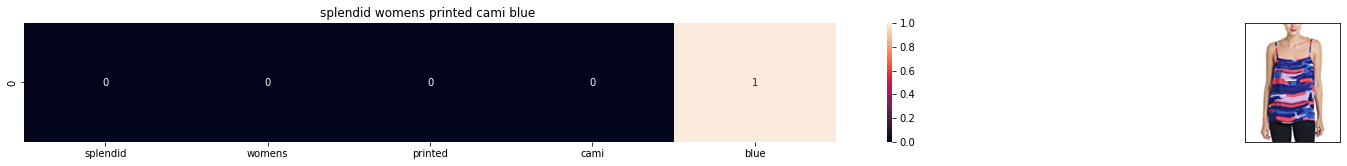

ASIN : B01N5XIJ0C
Brand: Splendid
Title: splendid womens printed cami blue 
Euclidean similarity with the query image : 3.7416573867739413


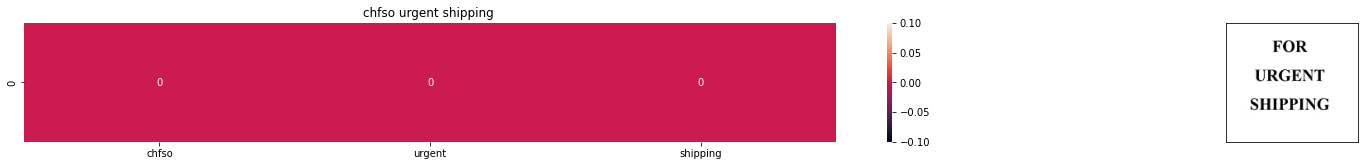

ASIN : B017JSX9OO
Brand: CHFSO
Title: chfso urgent shipping 
Euclidean similarity with the query image : 3.7416573867739413


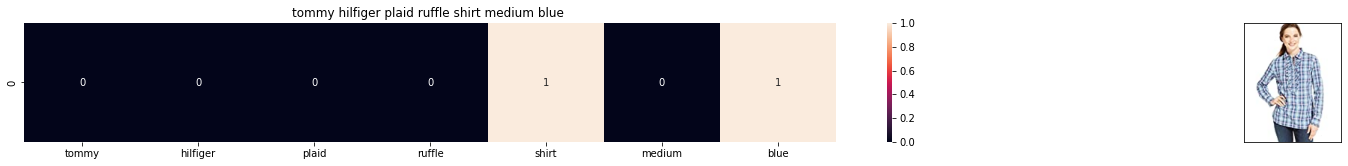

ASIN : B000HKAWWO
Brand: Tommy Hilfiger
Title: tommy hilfiger plaid ruffle shirt medium blue 
Euclidean similarity with the query image : 3.7416573867739413


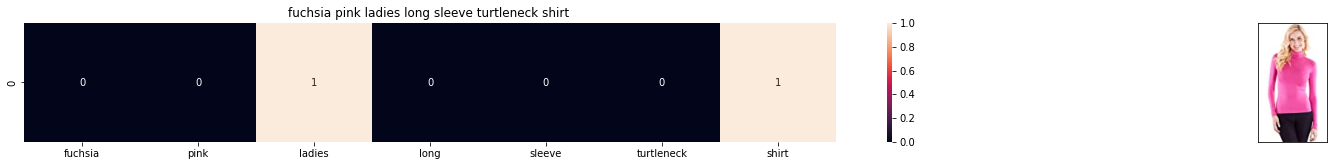

ASIN : B00EFG56Y0
Brand: Clothes Effect
Title: fuchsia pink ladies long sleeve turtleneck shirt 
Euclidean similarity with the query image : 3.7416573867739413


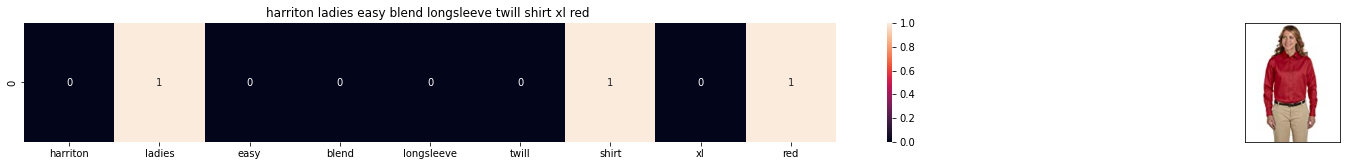

ASIN : B014WBSBQW
Brand: Harriton
Title: harriton ladies easy blend longsleeve twill shirt xl red 
Euclidean similarity with the query image : 3.7416573867739413


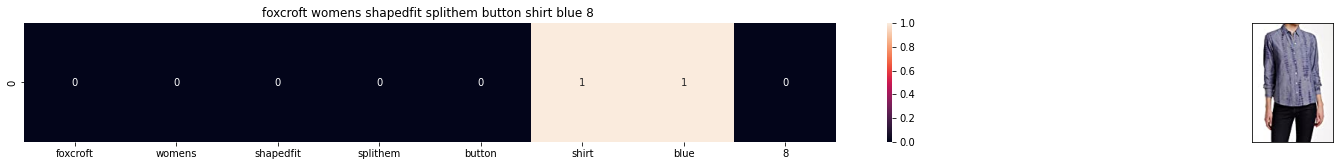

ASIN : B072J3NV8H
Brand: Foxcroft
Title: foxcroft womens shapedfit splithem button shirt blue 8 
Euclidean similarity with the query image : 3.7416573867739413


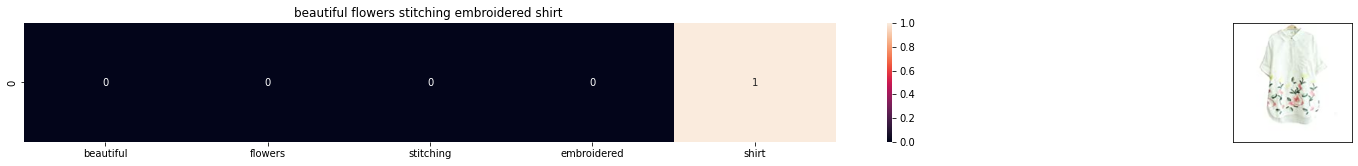

ASIN : B00WWMC56G
Brand: HP-LEISURE
Title: beautiful flowers stitching embroidered shirt 
Euclidean similarity with the query image : 3.7416573867739413


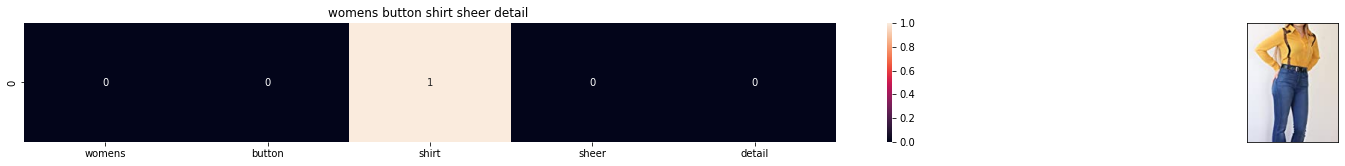

ASIN : B0756RHHHV
Brand: Have
Title: womens button shirt sheer detail 
Euclidean similarity with the query image : 3.7416573867739413


In [53]:
def bag_of_words_model(doc_id, num_results):
    #doc_id: apparel's id is givem to corpus 
    #pairwise dist will store the distance from the given input appare to 
    #remaining apparels ,the matrix we used here is cosine : the cosine dist
    # is measured as K(X,Y) = <X,Y>/|X||Y|
    
    pairwise_dist = pairwise_distances(title_features, title_features[doc_id])
    
    #np.argsort will return the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances 
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    #dataframe indices of the 9 smallest distances S
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

    

#call the bag of words model for a product to get similar products      
bag_of_words_model(777, 20) # change the index if you want to.
#In the output heat map each value reptresents the count value
# of the label word, the color represents the intersection
# with input titles

    
    

# TF-IDF based product similarity

In [54]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

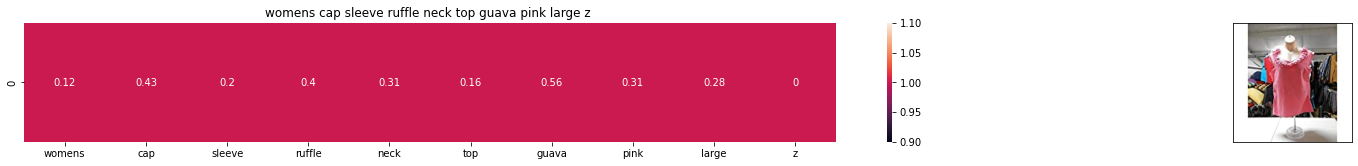

ASIN : B06XYLNQ38
BRAND : Z
Eucliden distance from the given image : 0.0


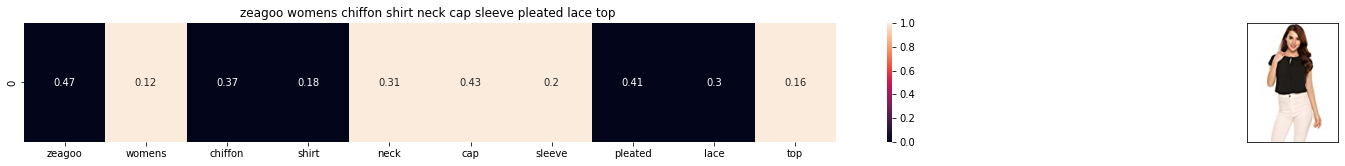

ASIN : B072KCRTKK
BRAND : Zeagoo
Eucliden distance from the given image : 1.1340938198827806


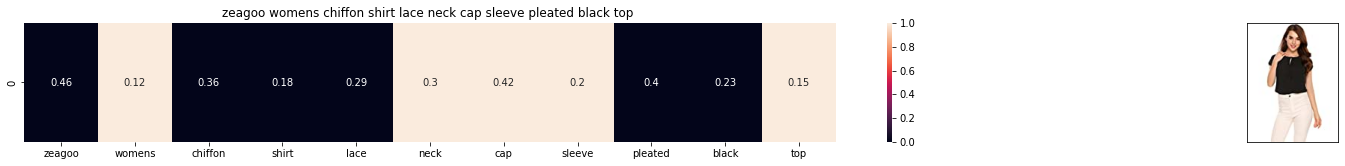

ASIN : B072MYLMVY
BRAND : Zeagoo
Eucliden distance from the given image : 1.1424229484913702


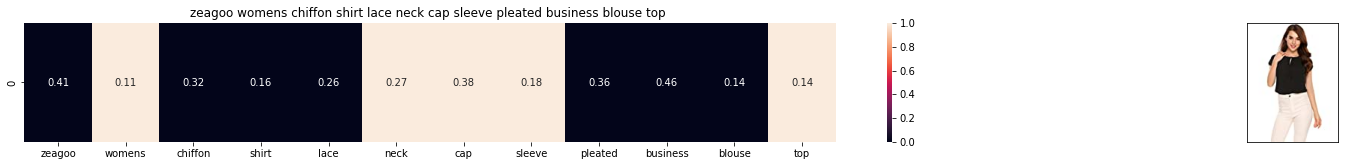

ASIN : B0721JDVV4
BRAND : Zeagoo
Eucliden distance from the given image : 1.1720929340082522


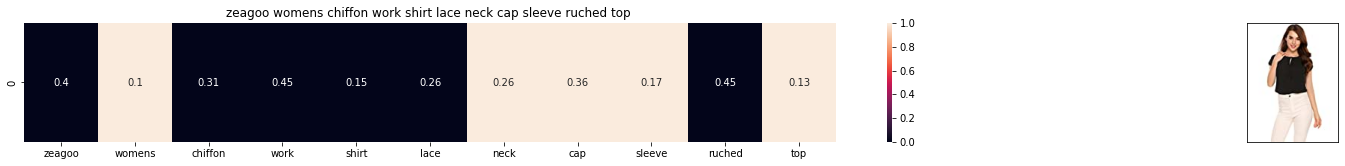

ASIN : B071GK7CNP
BRAND : Zeagoo
Eucliden distance from the given image : 1.1803081072163681


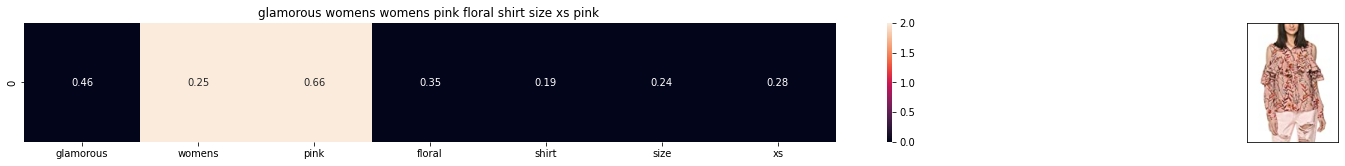

ASIN : B06XRSH45D
BRAND : Glamorous
Eucliden distance from the given image : 1.234856111231114


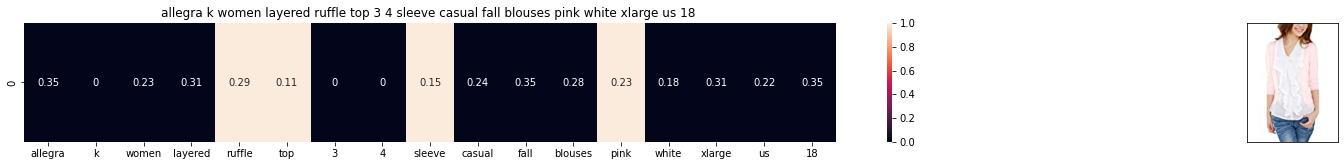

ASIN : B00DW39YCW
BRAND : Allegra K
Eucliden distance from the given image : 1.23871951611382


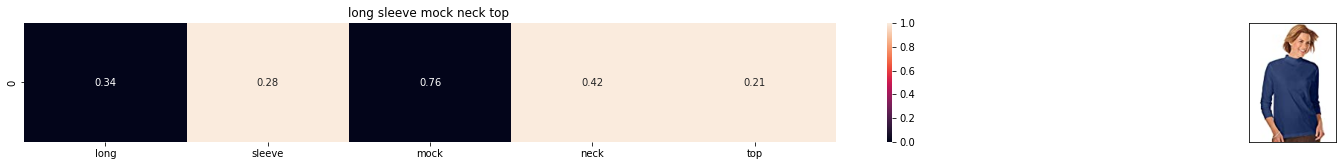

ASIN : B00KVN3EHW
BRAND : AmeriMark
Eucliden distance from the given image : 1.2506634435800408


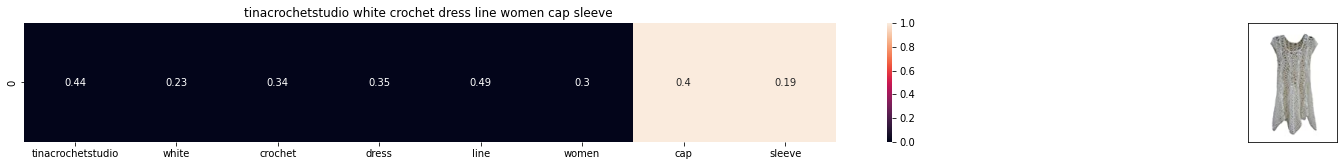

ASIN : B015Y4IX1O
BRAND : tinacrochetstudio
Eucliden distance from the given image : 1.2587138177188253


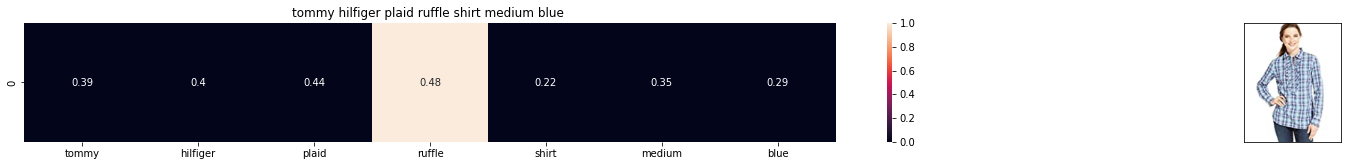

ASIN : B000HKAWWO
BRAND : Tommy Hilfiger
Eucliden distance from the given image : 1.2712010508658813


In [57]:
def tfidf_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
    
tfidf_model(730, 10)    